In [1]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [48]:
# Define the neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),  # Input: [S, tau]
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)   # Output: C
        )

    def forward(self, S, tau):
        inputs = torch.cat([S, tau], dim=1)
        return self.net(inputs)

# Define the loss function
def loss_function(model, S_pde, tau_pde, S_init, tau_init, S_bnd0, tau_bnd0, S_bnd_max, tau_bnd_max, K, r, sigma):
    # PDE loss
    S_pde.requires_grad_(True)
    tau_pde.requires_grad_(True)
    C_pde = model(S_pde, tau_pde)
    C_tau = torch.autograd.grad(C_pde, tau_pde, grad_outputs=torch.ones_like(C_pde), create_graph=True)[0]
    C_S = torch.autograd.grad(C_pde, S_pde, grad_outputs=torch.ones_like(C_pde), create_graph=True)[0]
    C_SS = torch.autograd.grad(C_S, S_pde, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    r_pde = -C_tau + 0.5 * sigma**2 * S_pde**2 * C_SS + r * S_pde * C_S - r * C_pde
    loss_pde = torch.mean(r_pde**2)


    # Initial condition
    C_init = model(S_init, tau_init)
    payoff = torch.max(S_init - K, torch.zeros_like(S_init))
    loss_init = torch.mean((C_init - payoff)**2)

    # Boundary conditions
    C_bnd0 = model(S_bnd0, tau_bnd0)
    loss_bnd0 = torch.mean(C_bnd0**2)
    C_bnd_max = model(S_bnd_max, tau_bnd_max)
    asymptotic = S_bnd_max - K * torch.exp(-r * tau_bnd_max)
    loss_bnd_max = torch.mean((C_bnd_max - asymptotic)**2)

    return loss_pde + loss_init + loss_bnd0 + loss_bnd_max

    

# Black-Scholes analytical solution
def black_scholes_call(S, tau, K, r, sigma):
    if tau == 0:
        return np.maximum(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)


    

In [3]:
# Parameters
K = 100
r = 0.05
sigma = 0.2
T = 1
S_max = 300

# Generate training data
N_pde = 10000
N_init = 1000
N_bnd = 1000

S_pde = torch.rand(N_pde, 1) * S_max
tau_pde = torch.rand(N_pde, 1) * T

S_init = torch.rand(N_init, 1) * S_max
tau_init = torch.zeros_like(S_init)

tau_bnd = torch.rand(N_bnd, 1) * T
S_bnd0 = torch.zeros_like(tau_bnd)
S_bnd_max = torch.ones_like(tau_bnd) * S_max

# Model, optimizer
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4]:
# Training loop
for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_function(model, S_pde, tau_pde, S_init, tau_init, S_bnd0, tau_bnd, S_bnd_max, tau_bnd, K, r, sigma)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 49884.28515625
Epoch 1000, Loss: 26119.298828125
Epoch 2000, Loss: 13220.626953125
Epoch 3000, Loss: 5831.369140625
Epoch 4000, Loss: 2085.731201171875
Epoch 5000, Loss: 589.635498046875
Epoch 6000, Loss: 160.63734436035156
Epoch 7000, Loss: 51.74864196777344
Epoch 8000, Loss: 2.018723487854004
Epoch 9000, Loss: 214.5072021484375


In [11]:
tau_eval.shape

torch.Size([101, 1])

In [29]:
def generate_t(T, steps, M, dt):
    t_temp = np.linspace(1e-6, T - 1e-6, steps + 1, dtype=np.float32)
    t_temp = T - t_temp
    return np.tile(t_temp, (M, 1))

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_60202/378770064.py:52: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))


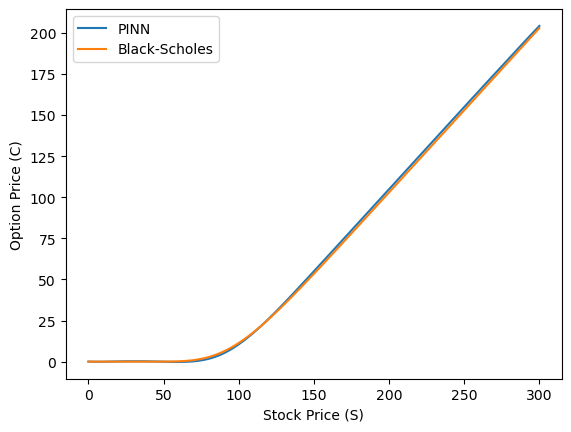

In [49]:
# Evaluation
S_eval = torch.linspace(0, S_max, 100).view(-1, 1)
#S_eval = torch.from_numpy(S_eval).float()


tau_eval = torch.ones_like(S_eval) * T
#tau_eval = torch.from_numpy(S_eval).float()

#tau_eval = generate_t(T, steps, 1, 0.01).T
#tau_eval = torch.from_numpy(tau_eval).float()

C_nn = model(S_eval, tau_eval).detach().numpy()
C_bs = [black_scholes_call(S.item(), T, K, r, sigma) for S in S_eval]
#C_bs = black_scholes_call(S_eval.numpy().reshape(-1), K, r, sigma, tau_eval.numpy().reshape(-1), T)

# Plot results
plt.plot(S_eval.numpy(), C_nn, label='PINN')
plt.plot(S_eval.numpy(), C_bs, label='Black-Scholes')
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Price (C)')
plt.legend()
plt.show()


